In [13]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision 
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import RandomErasing

In [14]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [15]:
#get data
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

#get current directory
base_dir = os.getcwd()

#go back one directory
base_dir = os.path.dirname(base_dir) 


# add crop to the directory
base_dir = os.path.join(base_dir, 'crop')

dataset = ImageFolder(root=base_dir, transform=transform)


In [16]:
# get training, validation, and testing data
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8)

In [17]:
image, label = train_dataset[0]
print(image.size(), label)

torch.Size([3, 256, 256]) 2


In [18]:
# these are the classes for the aircraft
class_names = ["A-10", "A-400M", "AG-600", "AH-64", "AV-8B", "An-124", "An-22", "An-225", "An-72", "B-1", "B-2", "B-21", "B-52", "Be-200", "C-130", "C-17", "C-2", "C-390", "C-5", "CH-47", "CL-415", "E-2", "E-7", "EF-2000", "F-117", "F-14", "F-15", "F-16", "F-22", "F-35", "F-4", "F/A-18", "H-6", "J-10", "J-20", "JAS-39", "JF-17", "JH-7", "KC-135", "KF-21", "KJ-600", "Ka-27", "Ka-52", "MQ-9", "Mi-24", "Mi-26", "Mi-28", "Mig-29", "Mig-31", "Mirage2000", "P-3", "RQ-4", "Rafale", "SR-71", "Su-24", "Su-25", "Su-34", "Su-57", "TB-001", "TB-2", "Tornado", "Tu-160", "Tu-22M", "Tu-95", "U-2", "UH-60", "US-2", "V-22", "Vulcan", "WZ-7", "XB-70", "Y-20", "YF-23", "Z-19"]

In [19]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.fc = nn.Linear(1000, 74)  # Change the output features to 74

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.fc(x)
        return x

In [20]:

net = NeuralNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Loaded pretrained weights for efficientnet-b0


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in range(10):
    print(f'Training epoch {epoch + 1}')
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f'Loss: {running_loss / len(train_loader): .4f}')

Training epoch 1
Loss:  3.1176
Training epoch 2
Loss:  1.7596
Training epoch 3
Loss:  1.2156
Training epoch 4
Loss:  0.9113
Training epoch 5
Loss:  0.7125
Training epoch 6
Loss:  0.5711
Training epoch 7
Loss:  0.4625
Training epoch 8
Loss:  0.3833
Training epoch 9
Loss:  0.3244
Training epoch 10
Loss:  0.2668


In [25]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

training_accuracy = correct / total
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

Training Accuracy: 98.83%


In [22]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accruacy = correct / total
print(f'Accuracy: {accruacy * 100:.2f}%')

Accuracy: 83.93%


In [23]:
best_val_accuracy = 0

# Validation Loop
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    current_val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {100 * correct / total}%")

    # Save the model if it has the best validation accuracy so far
    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy

Validation Accuracy: 84.28881313913853%


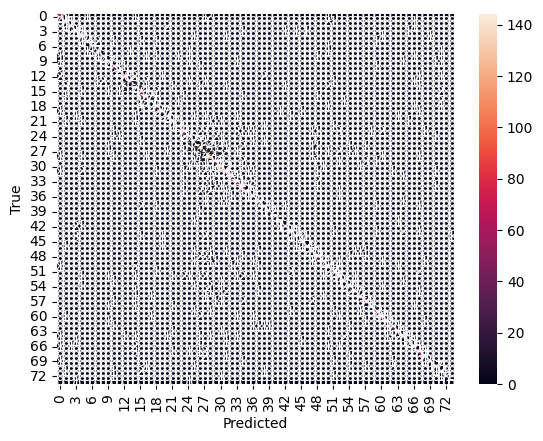

Test Accuracy: 83.9269123567668%


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test Loop with Confusion Matrix
net.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate and print test accuracy
correct = sum([1 for i, j in zip(all_labels, all_preds) if i == j])
total = len(all_labels)
print(f"Test Accuracy: {100 * correct / total}%")